Find vecicles in and around the vicinity of a particular area

 - choose samples where vehicles were along a road
 - compare vehicle positions against different bands




In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tifffile as tiff
from shapely.wkt import loads
from shapely import affinity

# living dangerously
import warnings
warnings.filterwarnings("ignore")

SVEHICLE_TYPE = 10
SVEHICLE_IMAGES = [ '6120_2_2',
    '6100_1_3', '6140_3_1','6110_3_1','6100_2_3',
    '6140_1_2','6120_2_0','6100_2_2','6110_1_2',
    '6070_2_3','6110_4_0','6090_2_0','6060_2_3'
]

PADDING = 10
W = 3396
H = 3348

def P(image_id):
    filename = os.path.join('input', 'sixteen_band', '{}_P.tif'.format(image_id))
    img = tiff.imread(filename)    
    return img

def RGB(image_id):
    filename = os.path.join('input', 'three_band', '{}.tif'.format(image_id))
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)    
    return img
    
def M(image_id):
    filename = os.path.join('input', 'sixteen_band', '{}_M.tif'.format(image_id))
    img = tiff.imread(filename)    
    img = np.rollaxis(img, 0, 3)
    return img

def stretch2(band, lower_percent=2, higher_percent=98):
    a = 0 #np.min(band)
    b = 255  #np.max(band)
    c = np.percentile(band, lower_percent)
    d = np.percentile(band, higher_percent)        
    out = a + (band - c) * (b - a) / (d - c)    
    out[out<a] = a
    out[out>b] = b
    return out

def adjust_contrast(x):    
    for i in range(3):
        x[:,:,i] = stretch2(x[:,:,i])
    return x.astype(np.uint8)
    
def truth_polys(image_id, class_id):
    x = pd.read_csv('input/train_wkt_v4.csv')
    rows = x.loc[(x.ImageId==image_id) & (x.ClassType==class_id), 'MultipolygonWKT']
    mp = loads(rows.values[0])
    
    grid_sizes = pd.read_csv('input/grid_sizes.csv')
    xmax, ymin = [(row[1], row[2]) for row in grid_sizes.values if row[0] == image_id][0]    
    W_ = W * (W/(W+1))
    H_ = H * (H/(H+1))
    x_scaler = W_ / xmax
    y_scaler = H_ / ymin
    return affinity.scale(mp, xfact = x_scaler, yfact= y_scaler, origin=(0,0,0))
    

In [10]:
    
    patches = []
    titles = []
    for image_id in SVEHICLE_IMAGES:
        print(image_id)
        polys = truth_polys(image_id, SVEHICLE_TYPE)                
        rgb = RGB(image_id)
        #rgb = adjust_contrast(rgb)        
        #rgb = rgb.copy().astype(np.uint8)        
        img_p = P(image_id)
        img_p = cv2.resize(img_p, tuple(reversed(rgb.shape[:2])))        
        img_p = cv2.cvtColor(img_p, cv2.COLOR_GRAY2RGB)        
        img_p = adjust_contrast(img_p)
        
        img_m = M(image_id)
        img_m = cv2.resize(img_m, tuple(reversed(rgb.shape[:2])))                
        x = np.zeros_like(rgb)
        x[:,:,0] = img_m[:,:,4]
        x[:,:,1] = img_m[:,:,2]
        x[:,:,2] = img_m[:,:,1]
        x = adjust_contrast(x).copy()
                        
        for poly_id, poly in enumerate(polys):
            x1,y1,x2,y2 = [int(x) for x in poly.bounds]
            pts = np.array(poly.exterior.coords.xy, dtype=np.int32).transpose()
            # suggestion from RafalG
            cv2.polylines(x, [pts], 1, (255,0,0), 1, 16)            
            cv2.polylines(img_p, [pts], 1, (255,0,0), 1, 16)               
            #cv2.rectangle(x, (x1,y1), (x2,y2), (255,0,0), 1)
            #cv2.rectangle(img_p, (x1,y1), (x2,y2), (255,0,0), 1)
            patches.append(np.hstack([x[y1-PADDING:y2+PADDING, x1-PADDING:x2+PADDING,:], img_p[y1-PADDING:y2+PADDING, x1-PADDING:x2+PADDING,:]]))
            titles.append("image_id: {} -- poly_id: {}".format(image_id, poly_id))

    

6120_2_2
6100_1_3
6140_3_1
6110_3_1
6100_2_3
6140_1_2
6120_2_0
6100_2_2
6110_1_2
6070_2_3
6110_4_0
6090_2_0
6060_2_3


ValueError: zero-size array to reduction operation minimum which has no identity

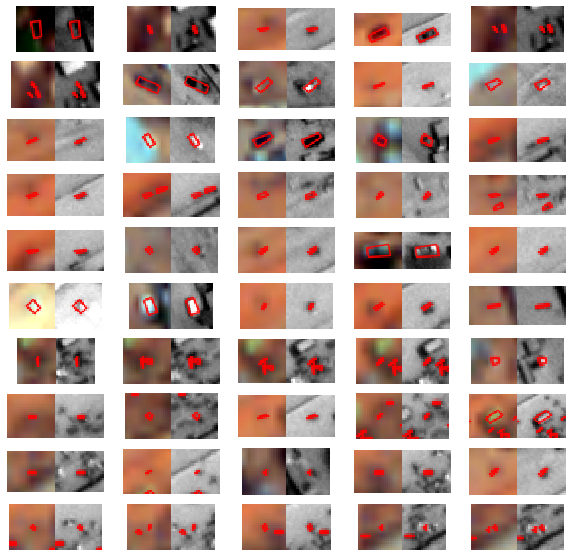

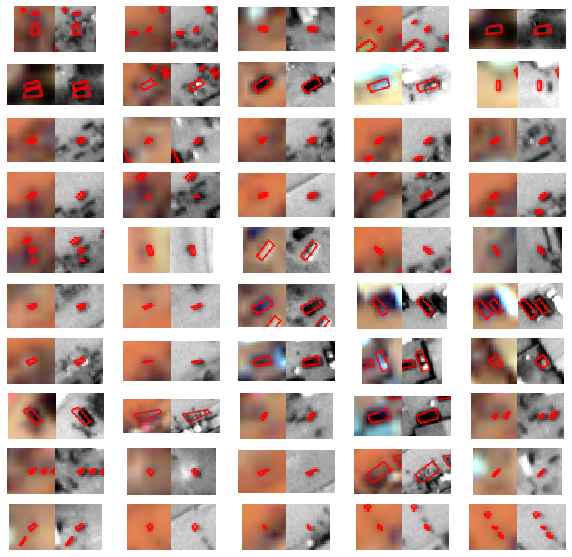

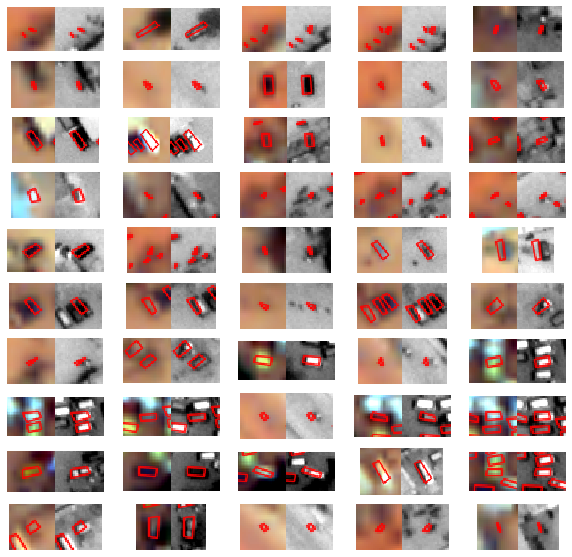

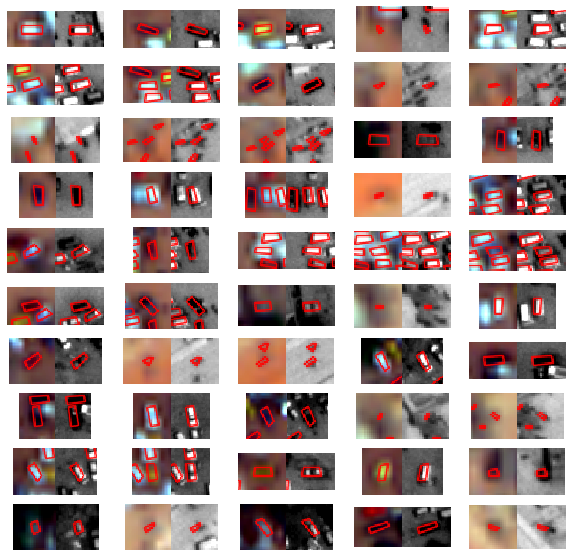

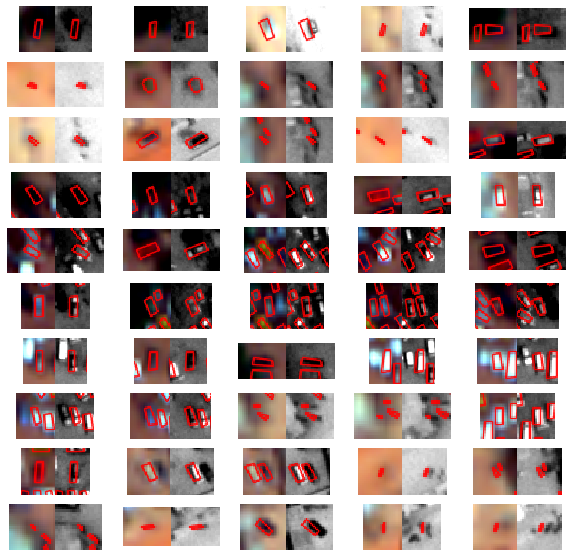

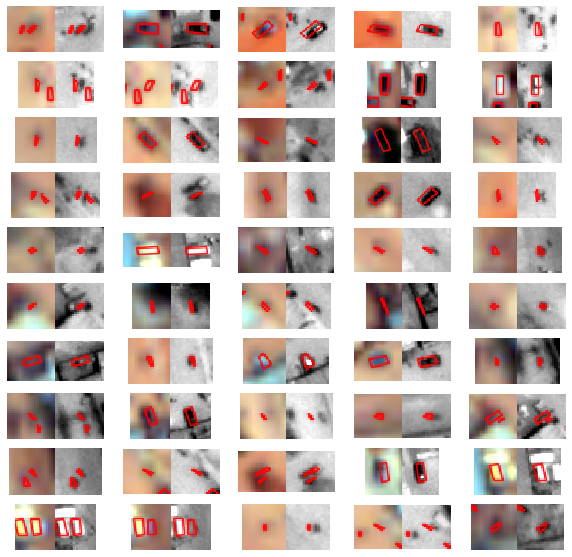

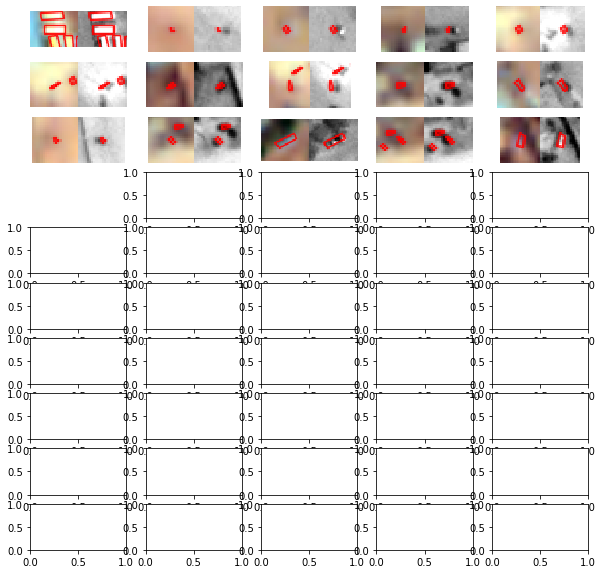

In [15]:
    #random = np.arange(len(patches))
    #np.random.shuffle(random)
    c = 0
    for _ in range(15):
        rows = 10
        cols = 5
        f, ax = plt.subplots(rows, cols, figsize=(10,10))
        for i in range(rows):
            for j in range(cols):                
                c += 1
                if c >= len(patches):
                    break
                ax[i,j].axis('off')
                ax[i,j].grid(False)
                ax[i,j].imshow(patches[c])                
                #ax[i, j].set_title(titles[c])
